In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)
# Uncomment the follwing line to enabled devlib debugging statements
#logging.getLogger('ssh').setLevel(logging.DEBUG)

In [2]:
# Generate plots inline
%pylab inline

import copy
import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Support for trace events analysis
from trace import Trace
from trace_analysis import TraceAnalysis

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


# Test environment setup

In [3]:
# Setup a target configuration
my_target_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'linux',  # Linux system, valid other options are:
                              # android - access via ADB
                              # linux   - access via SSH
                              # host    - direct access
    
    # Preload settings for a specific target
    "board"       : 'juno',   # load JUNO specific settings, e.g.
                              # - HWMON based energy sampling
                              # - Juno energy model
                              # valid options are:
                              # - juno  - JUNO Development Board
                              # - tc2   - TC2 Development Board
                              # - oak   - Mediatek MT63xx based target

    # Define devlib module to load
    "modules"     : [
        'bl',           # enable big.LITTLE support
        'cpufreq'       # enable CPUFreq support
    ],

    # Account to access the remote target
    "host"        : '192.168.0.10',
    "username"    : 'root',
    "password"    : '',

    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
        '0': 361, '1': 138, '2': 138, '3': 352, '4': 360, '5': 353
    }

}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Additional devlib modules required for this experiment
    "modules" : ['hwmon'],
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
             "sched_switch",
             "sched_load_avg_cpu",
             "cpu_frequency",
             "cpu_capacity"
         ],
         "buffsize" : 10240
    },

}

In [4]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

04:22:20  INFO    :         Target - Using base path: /home/derkling/Code/schedtest
04:22:20  INFO    : %14s - Loading custom (inline) target configuration
04:22:20  INFO    :         Target - Connecting linux target with: {'username': 'root', 'host': '192.168.0.10', 'password': ''}
04:22:57  INFO    :         Target - Initializing target workdir [/root/devlib-target]
04:23:01  INFO    : Target topology: [[0, 3, 4, 5], [1, 2]]
04:23:03  INFO    :         FTrace - Enabled events:
04:23:03  INFO    :         FTrace -   ['sched_switch', 'sched_load_avg_cpu', 'cpu_frequency', 'cpu_capacity']
04:23:03  INFO    :    EnergyMeter - Channels selected for energy sampling:
[CHAN(v2m_juno_energy/energy1, a57_energy), CHAN(v2m_juno_energy/energy1, a53_energy)]
04:23:03  INFO    : Loading RTApp calibration from configuration file...
04:23:03  INFO    : Using RT-App calibration values: {0: 361, 1: 138, 2: 138, 3: 352, 4: 360, 5: 353}


In [5]:
logging.info("Target ABI: %s, CPus: %s",
             target.abi,
             target.cpuinfo.cpu_names)

04:23:03  INFO    : Target ABI: arm64, CPus: ['A53', 'A57', 'A57', 'A53', 'A53', 'A53']


# Support functions

These are a set of functions to run a workload with different CPUFreq configurations

In [6]:
def set_performance():
    target.cpufreq.set_all_governors('performance')

def set_powersave():
    target.cpufreq.set_all_governors('powersave')

def set_interactive():
    target.cpufreq.set_all_governors('interactive')

def set_sched():
    target.cpufreq.set_all_governors('sched')

def set_ondemand():
    target.cpufreq.set_all_governors('ondemand')
    
    # Configure the MAX sampling rate supporte by the LITTLE cores
    littles_tunables = target.cpufreq.get_governor_tunables(
                            target.bl.littles[0])
    target.cpufreq.set_governor_tunables(
        target.bl.littles[0], 'ondemand',
        **{'sampling_rate' : littles_tunables['sampling_rate_min']}
    )
    
    # Configure the MAX sampling rate supporte by the big cores
    bigs_tunables = target.cpufreq.get_governor_tunables(
                            target.bl.bigs[0])
    target.cpufreq.set_governor_tunables(
        target.bl.bigs[0], 'ondemand',
        **{'sampling_rate' : bigs_tunables['sampling_rate_min']}
    )
    

In [7]:
# CPUFreq configurations to test
confs = {
    'performance' : {
        'label' : 'prf',
        'set' :  set_performance,
    },
    'powersave' : {
        'label' : 'pws',
        'set' :  set_powersave,
    },
    'interactive' : {
        'label' : 'int',
        'set' :  set_interactive,
    },
    'sched' : {
        'label' : 'sch',
        'set' :  set_sched,
    },
    'ondemand' : {
        'label' : 'odm',
        'set' :  set_ondemand,
    }
}

# The set of results forlder for each comparition test
results = {}

In [8]:
def experiment(governor, rtapp, exp_dir):
    os.system('mkdir -p {}'.format(exp_dir));

    logging.info('------------------------')
    logging.info('Run workload using %s governor', governor)
    confs[governor]['set']()

    # Start FTrace and Energy monitoring
    te.ftrace.start()
    te.emeter.reset()
    
    # Run the workload
    rtapp.run(out_dir=exp_dir)
    
    # Stop FTrace and sample Energy consumption
    nrg = te.emeter.sample()
    te.ftrace.stop()
    
    logging.info('Energy: %s', nrg)
    
    # Dump platform description
    te.platform_dump(exp_dir)
    
    # Collect and keep track of the trace
    trace_file = os.path.join(exp_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Parse trace
    tr = Trace(te.platform, exp_dir,
               events=my_tests_conf['ftrace']['events'])
    ta = TraceAnalysis(tr, te.platform)
    
    # return all the experiment data
    return {
        'dir'      : exp_dir,
        'energy'   : nrg,
        'trace'    : trace_file,
        'ftrace'   : tr.ftrace,
        'ta'       : ta
    }

    
def compare(tid, rtapp):    
    logging.info('Test case: %s', tid)
    
    res_dir = os.path.join(te.res_dir, tid)
    logging.info('  results folder: %s', res_dir)
    
    # Run the workload in all the configured governors
    results[tid] = {}
    for governor in confs:
        test_dir = os.path.join(res_dir, governor)
        res = experiment(governor, rtapp, test_dir)
        results[tid][governor] = copy.deepcopy(res)
        
def plot(tid):
    global results
    
    for governor in confs:
        plot_title = "{} Governor".format(governor.upper())
        trappy.LinePlot(results[tid][governor]['ftrace'],
                        templates,
                        column=column,
                        pivot="cpu",
                        filters={"cpu": [1]},
                        marker = '+',
                        drawstyle='steps-post',
                        title=plot_title,
                        ylim=(0, 1100)).view()
        
    for governor in confs:
        pa = PerfAnalysis(results[tid][governor]['dir'])
        for task in pa.tasks():
            pa.plotPerf(task, "Performance using [{}] governor"\
                                .format(governor))
        
def report_nrg(tid):
    global results
    
    print "{:15s} | {:>9s} {:>9s} {:>9s}"\
        .format('Governor', 'A53', 'A57', 'Total')
    print "{:-<16s}+{:-<30s}".format('', '')
    for governor in confs:
        plot_title = "{}".format(governor.upper())
        nrg = results[tid][governor]['energy']
        nrg_little = float(nrg['a53']['delta'])
        nrg_big = float(nrg['a57']['delta'])
        nrg_sum = nrg_little + nrg_big
        print "{:15s} | {:9.3f} {:9.3f} {:9.3f}"\
            .format(governor, nrg_little, nrg_big, nrg_sum)

# Test: light/heavy/light

In [9]:
# Define a label for this test case
test_case = 'light-heavy-light'

rtapp = RTA(target, 'smoke', calibration=te.calibration())
rtapp.conf(
    kind='profile',
    params={
        'task1' : {
            'phases' : [
                # duration [s]
                # |     period [ms]
                # |     |      duty-cycle [%]
                # |     |      |
                 (1.0,  10,   10),
                 (0.1, 100,   90),
                 (1.0,  10,   10)
            ],
            'cpus': str(target.bl.bigs_online[0])
        }
    },
    run_dir=target.working_directory
);

04:38:33  INFO    : Setup new workload smoke
04:38:33  INFO    : Workload duration defined by longest task
04:38:33  INFO    : Default policy: SCHED_OTHER
04:38:33  INFO    : ------------------------
04:38:33  INFO    : task [task1], sched: using default policy
04:38:33  INFO    :  | loops count: 1
04:38:33  INFO    :  | CPUs affinity: 1
04:38:33  INFO    :  + phase_000001: duration 1.000000 [s] (100 loops)
04:38:33  INFO    :  |  period    10000 [us], duty_cycle  10 %
04:38:33  INFO    :  |  run_time   1000 [us], sleep_time   9000 [us]
04:38:33  INFO    :  + phase_000002: duration 0.100000 [s] (1 loops)
04:38:33  INFO    :  |  period   100000 [us], duty_cycle  90 %
04:38:33  INFO    :  |  run_time  90000 [us], sleep_time  10000 [us]
04:38:33  INFO    :  + phase_000003: duration 1.000000 [s] (100 loops)
04:38:33  INFO    :  |  period    10000 [us], duty_cycle  10 %
04:38:33  INFO    :  |  run_time   1000 [us], sleep_time   9000 [us]


In [10]:
# Run this workload in all the configurations
compare(test_case, rtapp)

04:38:34  INFO    : Test case: light-heavy-light
04:38:34  INFO    :   results folder: /home/derkling/Code/schedtest/results/20151204_162303/light-heavy-light
04:38:34  INFO    : ------------------------
04:38:34  INFO    : Run workload using performance governor
04:38:39  INFO    : Executor [start]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json
04:38:41  INFO    : Executor [end]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json
04:38:43  INFO    : Energy: {'a53': {'total': 0.8490520000000288, 'last': 524.695704, 'delta': 0.8490520000000288}, 'a57': {'total': 4.111157000000048, 'last': 681.453031, 'delta': 4.111157000000048}}
04:38:46  INFO    : Collected events spans a 5.828 [s] time interval
04:38:46  INFO    : Set plots time range to (0.000000, 5.827563)[s]
04:38:46  INFO    : ------------------------
04:38:46  INFO    : Run workload using sched governor
04:38:51  INFO    : Executor [start]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_

In [11]:
# Plot all data collected from experiments
def plot(tid):
    global results
    
    # Plot CPU LoadAvg and Capacity (for CPU0)
    for governor in confs:
        plot_title = "{} Governor".format(governor.upper())
        trappy.LinePlot(results[tid][governor]['ftrace'],
                        signals=[
                            "sched_load_avg_cpu:util_avg",
                            "cpu_capacity:capacity"],
                        pivot="cpu",
                        filters={"cpu": [1]},
                        marker = '+',
                        drawstyle='steps-post',
                        title=plot_title,
                        ylim=(0, 1100)).view()
    
    # Plot Custer Frequencies and report averate frequencies
    for governor in confs:
        plot_title = "Cluster frequencies, {}".format(governor.upper())
        ta = results[tid][governor]['ta']
        logging.info("%s:", plot_title)
        ta.plotClusterFrequencies(title=plot_title)
    
    # Plot RTApp performance index
    for governor in confs:
        plot_title = "RTApp performances, {}".format(governor.upper())
        pa = PerfAnalysis(results[tid][governor]['dir'])
        logging.info("%s:", plot_title)
        for task in pa.tasks():
            pa.plotPerf(task, "Performance using [{}] governor"\
                                .format(governor))
            

04:39:47  INFO    : Cluster frequencies, PERFORMANCE:
04:39:47  WARNING : Events [sched_cpu_frequency] not found, plot DISABLED!
04:39:47  INFO    : Cluster frequencies, SCHED:
04:39:47  WARNING : Events [sched_cpu_frequency] not found, plot DISABLED!
04:39:47  INFO    : Cluster frequencies, POWERSAVE:
04:39:47  WARNING : Events [sched_cpu_frequency] not found, plot DISABLED!
04:39:47  INFO    : Cluster frequencies, ONDEMAND:
04:39:47  WARNING : Events [sched_cpu_frequency] not found, plot DISABLED!
04:39:47  INFO    : Cluster frequencies, INTERACTIVE:
04:39:47  WARNING : Events [sched_cpu_frequency] not found, plot DISABLED!
04:39:47  INFO    : RTApp performances, PERFORMANCE:
04:39:47  INFO    : PerfIndex, Task [task1] avg: 0.95, std: 0.01
04:39:47  INFO    : RTApp performances, SCHED:
04:39:47  INFO    : PerfIndex, Task [task1] avg: 0.70, std: 0.45
04:39:48  INFO    : RTApp performances, POWERSAVE:
04:39:48  INFO    : PerfIndex, Task [task1] avg: 0.08, std: 2.53
04:39:48  INFO    : 

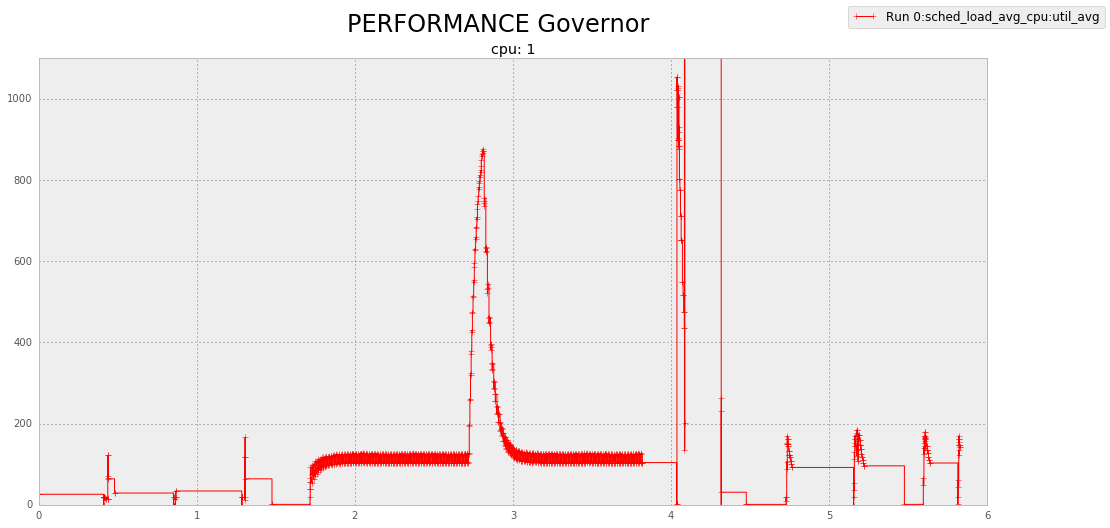

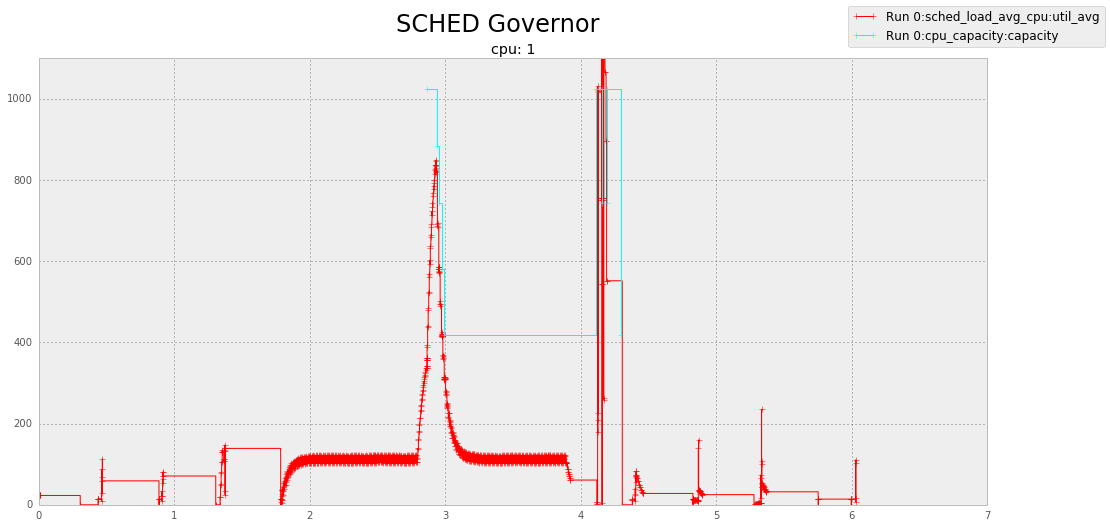

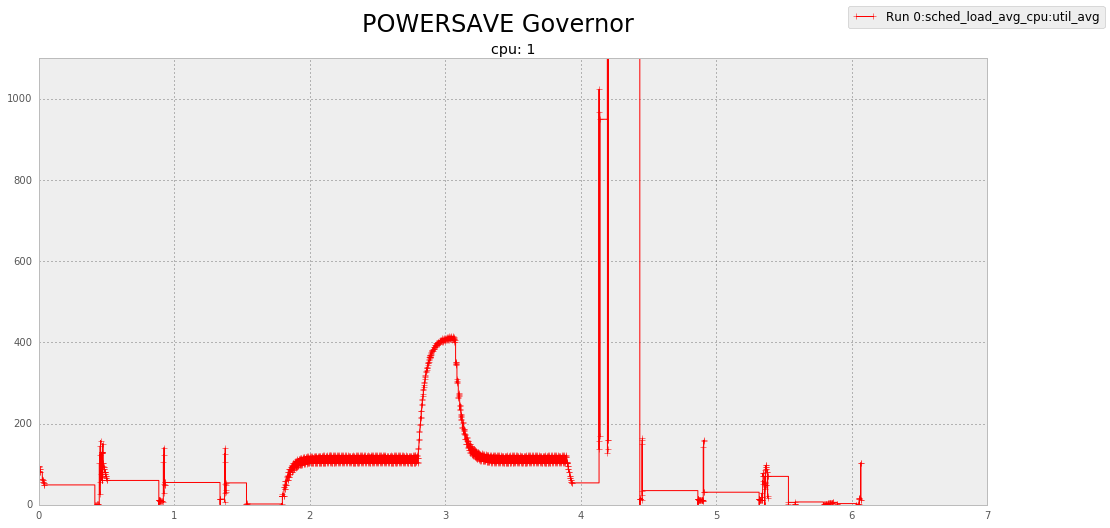

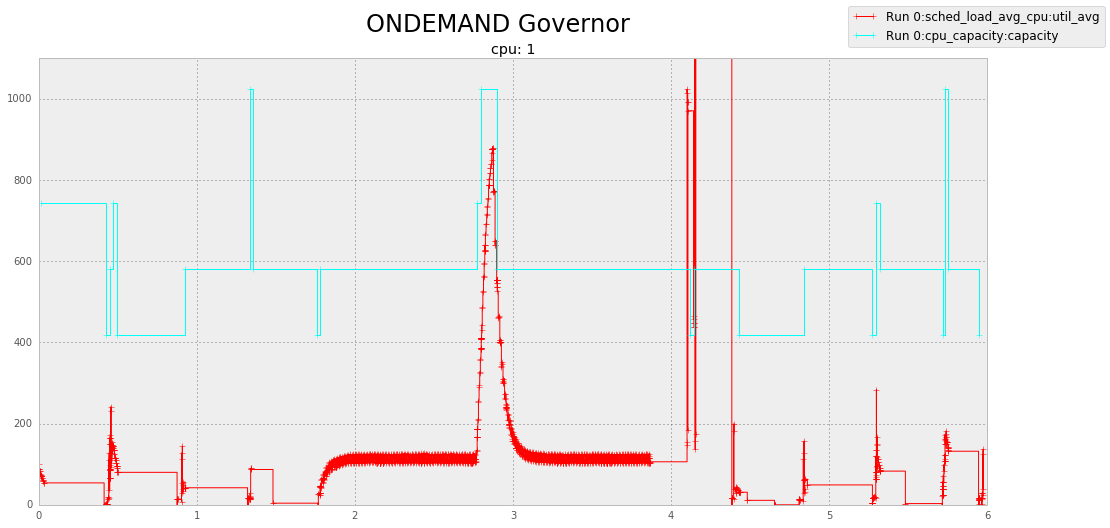

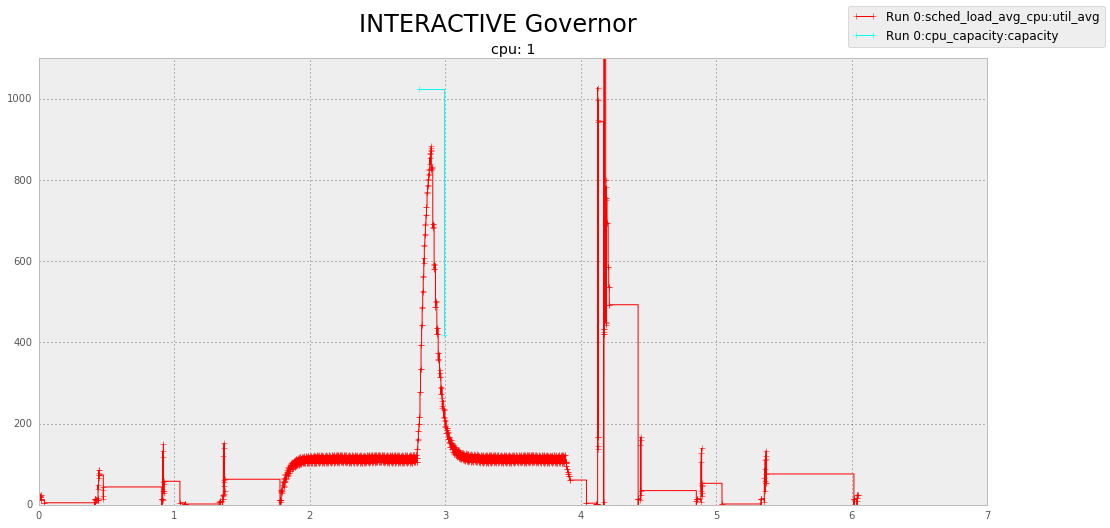

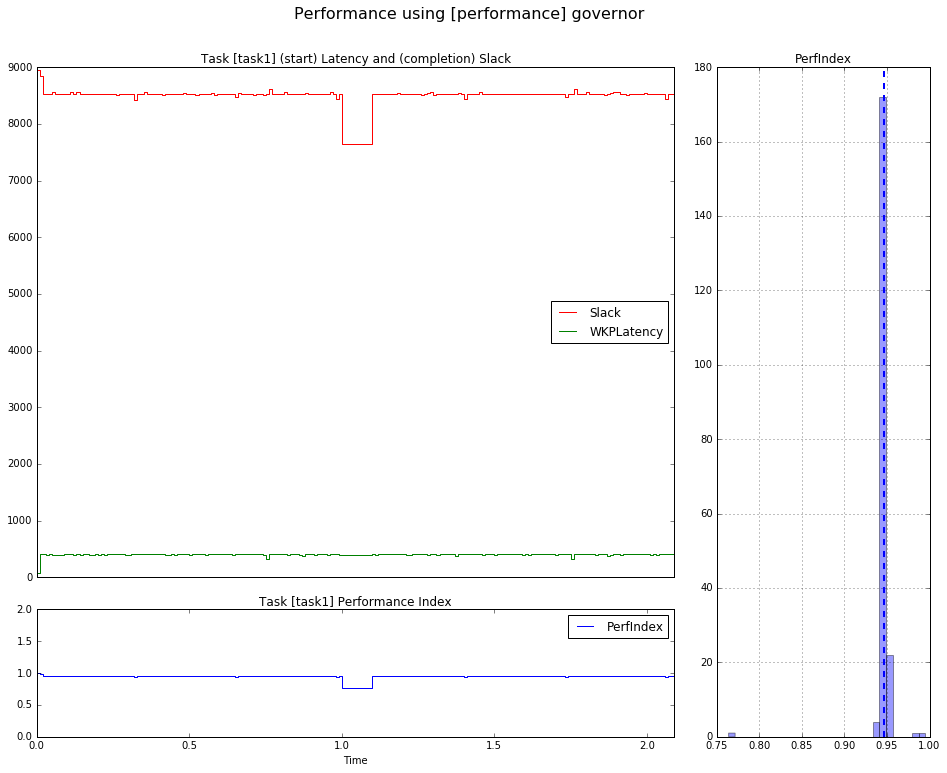

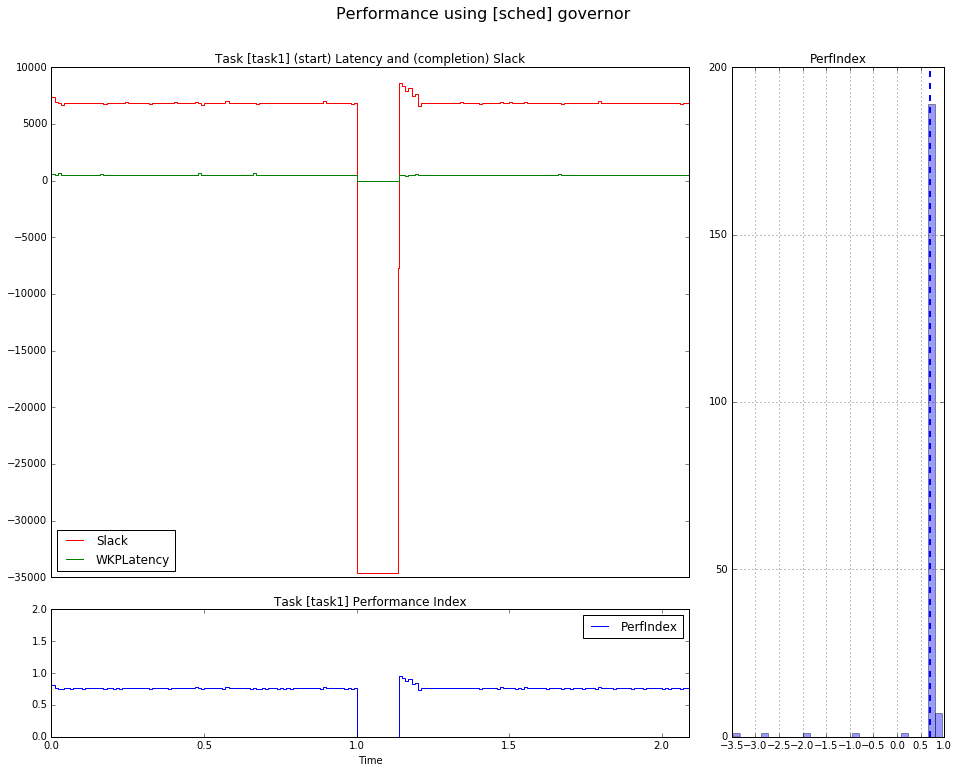

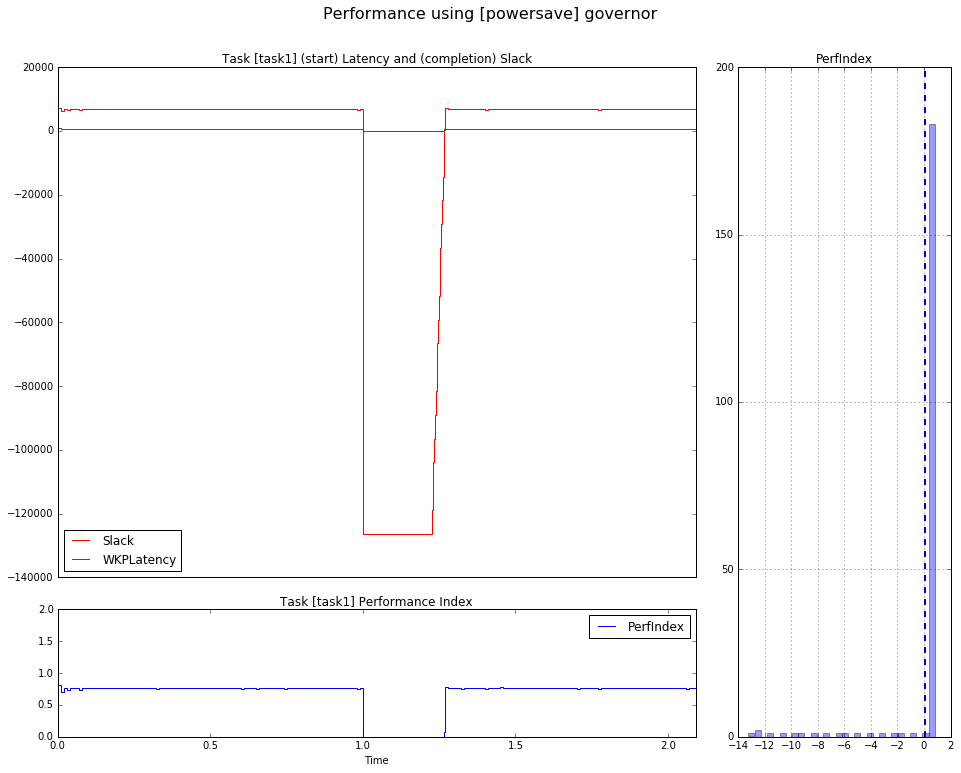

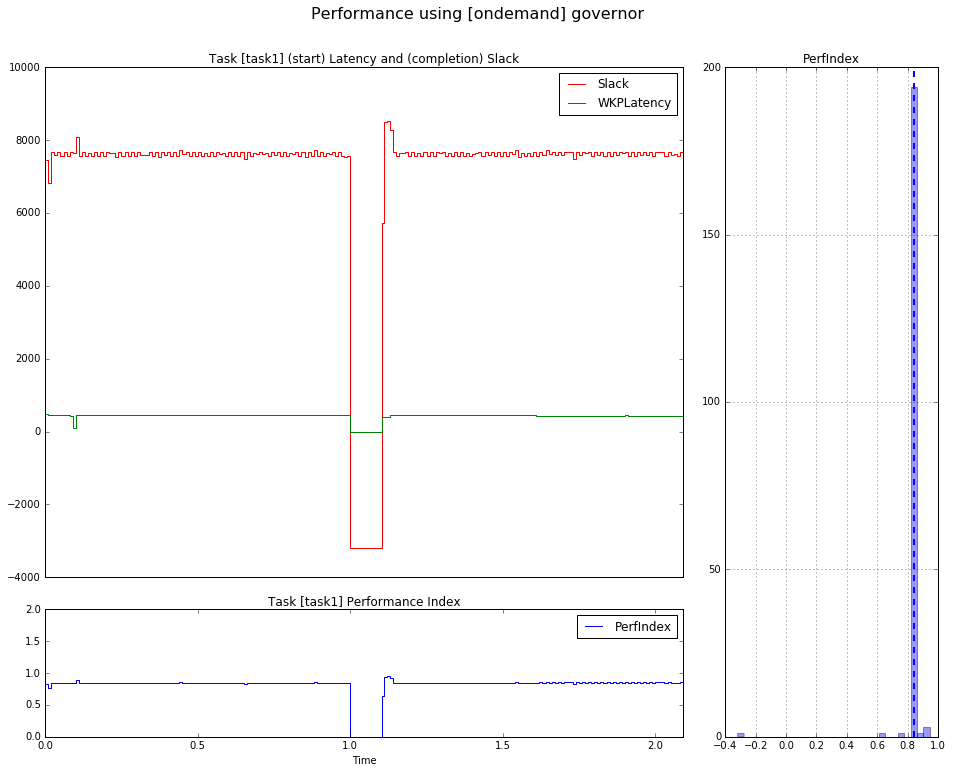

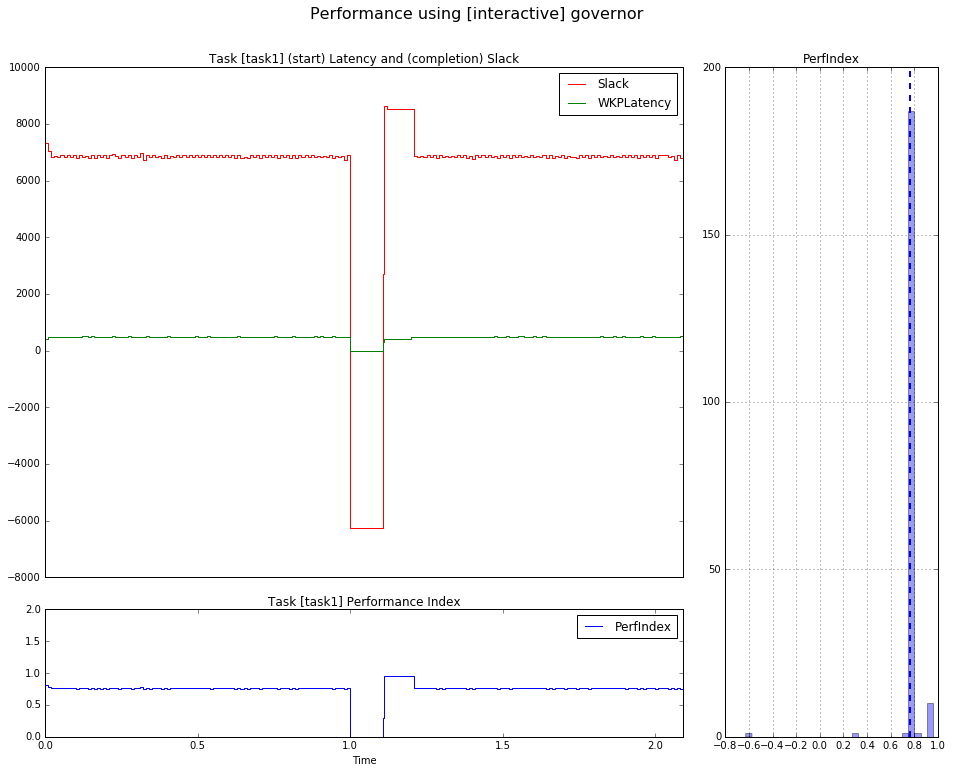

In [12]:
plot(test_case)

In [13]:
report_nrg(test_case)

Governor        |       A53       A57     Total
----------------+------------------------------
performance     |     0.849     4.111     4.960
sched           |     0.590     2.909     3.499
powersave       |     0.573     2.446     3.019
ondemand        |     0.677     2.957     3.634
interactive     |     0.570     2.845     3.415


# Test: light/heavy/medium

In [14]:
# Define a label for this test case
test_case = 'light-heavy-medium'

rtapp = RTA(target, 'smoke', calibration=te.calibration())
rtapp.conf(
    kind='profile',
    params={
        'task1' : {
            'phases' : [
                # duration [s]
                # |     period [ms]
                # |     |      duty-cycle [%]
                # |     |      |
                 (1.0,  10,   10),
                 (0.1, 100,   90),
                 (1.0,  10,   50)
            ],
            'cpus': str(target.bl.bigs_online[0])
        }
    },
    run_dir=target.working_directory
);

04:39:51  INFO    : Setup new workload smoke
04:39:51  INFO    : Workload duration defined by longest task
04:39:51  INFO    : Default policy: SCHED_OTHER
04:39:51  INFO    : ------------------------
04:39:51  INFO    : task [task1], sched: using default policy
04:39:51  INFO    :  | loops count: 1
04:39:51  INFO    :  | CPUs affinity: 1
04:39:51  INFO    :  + phase_000001: duration 1.000000 [s] (100 loops)
04:39:51  INFO    :  |  period    10000 [us], duty_cycle  10 %
04:39:51  INFO    :  |  run_time   1000 [us], sleep_time   9000 [us]
04:39:51  INFO    :  + phase_000002: duration 0.100000 [s] (1 loops)
04:39:51  INFO    :  |  period   100000 [us], duty_cycle  90 %
04:39:51  INFO    :  |  run_time  90000 [us], sleep_time  10000 [us]
04:39:51  INFO    :  + phase_000003: duration 1.000000 [s] (100 loops)
04:39:51  INFO    :  |  period    10000 [us], duty_cycle  50 %
04:39:51  INFO    :  |  run_time   5000 [us], sleep_time   5000 [us]


In [15]:
# Run this workload in all the configurations
compare(test_case, rtapp)

04:39:51  INFO    : Test case: light-heavy-medium
04:39:51  INFO    :   results folder: /home/derkling/Code/schedtest/results/20151204_162303/light-heavy-medium
04:39:51  INFO    : ------------------------
04:39:51  INFO    : Run workload using performance governor
04:39:56  INFO    : Executor [start]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json
04:39:59  INFO    : Executor [end]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json
04:40:01  INFO    : Energy: {'a53': {'total': 0.8941800000000057, 'last': 550.496184, 'delta': 0.8941800000000057}, 'a57': {'total': 7.2930220000000645, 'last': 725.70875, 'delta': 7.2930220000000645}}
04:40:03  INFO    : Collected events spans a 5.840 [s] time interval
04:40:03  INFO    : Set plots time range to (0.000000, 5.839702)[s]
04:40:04  INFO    : ------------------------
04:40:04  INFO    : Run workload using sched governor
04:40:09  INFO    : Executor [start]: /root/devlib-target/bin/rt-app /root/devlib-target/smo

04:41:05  INFO    : Cluster frequencies, PERFORMANCE:
04:41:05  WARNING : Events [sched_cpu_frequency] not found, plot DISABLED!
04:41:05  INFO    : Cluster frequencies, SCHED:
04:41:05  WARNING : Events [sched_cpu_frequency] not found, plot DISABLED!
04:41:05  INFO    : Cluster frequencies, POWERSAVE:
04:41:05  WARNING : Events [sched_cpu_frequency] not found, plot DISABLED!
04:41:05  INFO    : Cluster frequencies, ONDEMAND:
04:41:05  WARNING : Events [sched_cpu_frequency] not found, plot DISABLED!
04:41:05  INFO    : Cluster frequencies, INTERACTIVE:
04:41:05  WARNING : Events [sched_cpu_frequency] not found, plot DISABLED!
04:41:05  INFO    : RTApp performances, PERFORMANCE:
04:41:05  INFO    : PerfIndex, Task [task1] avg: 0.91, std: 0.04
04:41:06  INFO    : RTApp performances, SCHED:
04:41:06  INFO    : PerfIndex, Task [task1] avg: 0.49, std: 0.87
04:41:06  INFO    : RTApp performances, POWERSAVE:
04:41:06  INFO    : PerfIndex, Task [task1] avg: -25.11, std: 28.00
04:41:07  INFO   

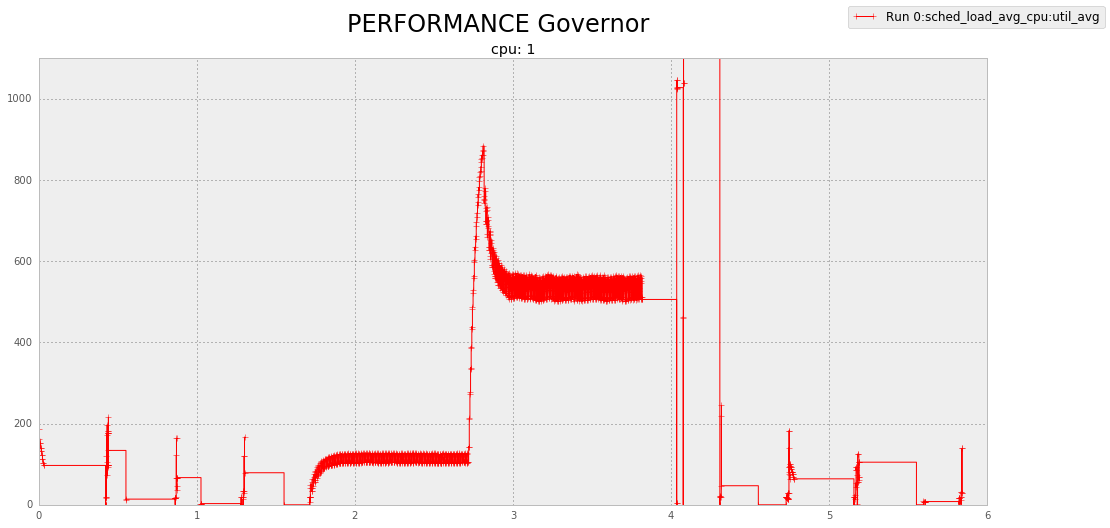

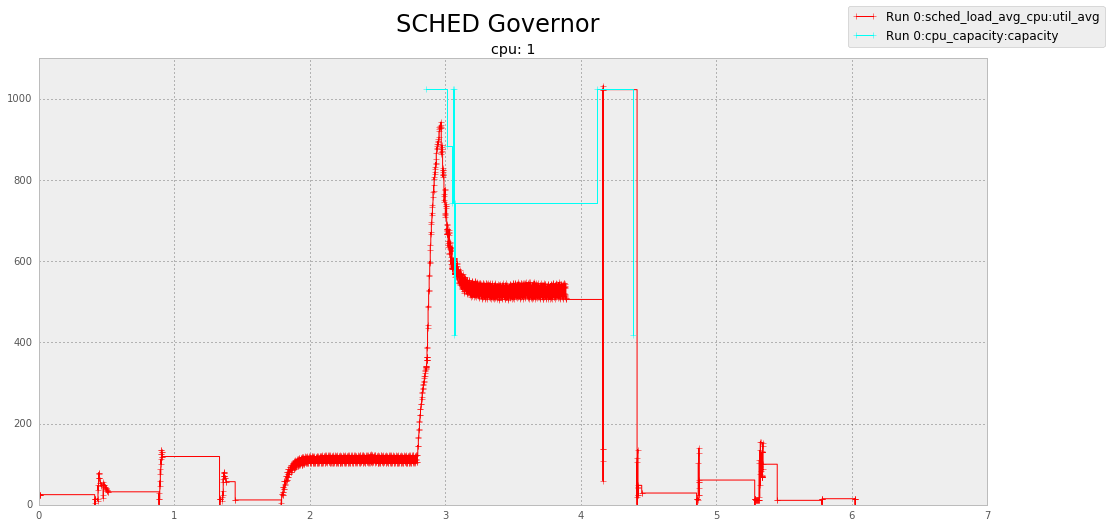

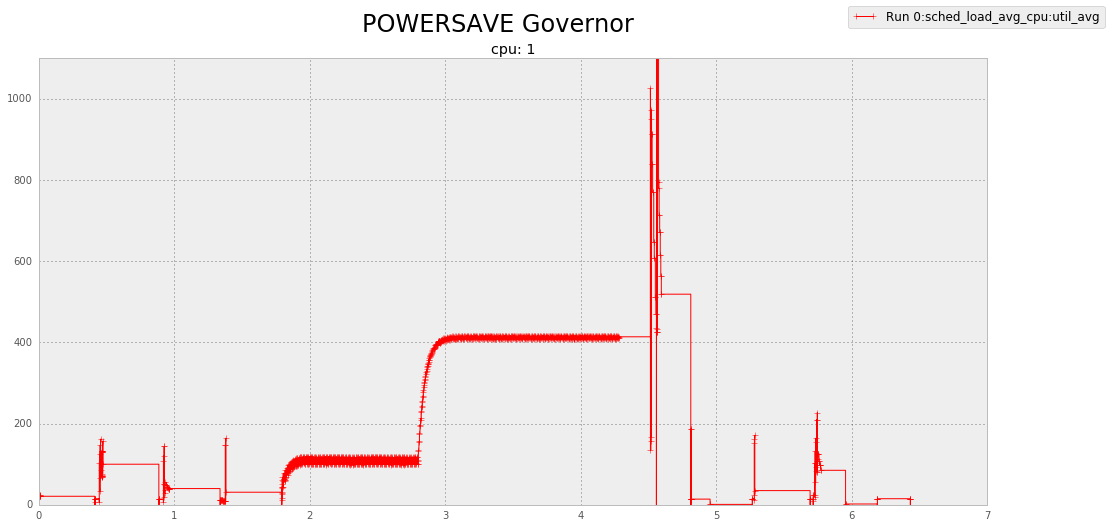

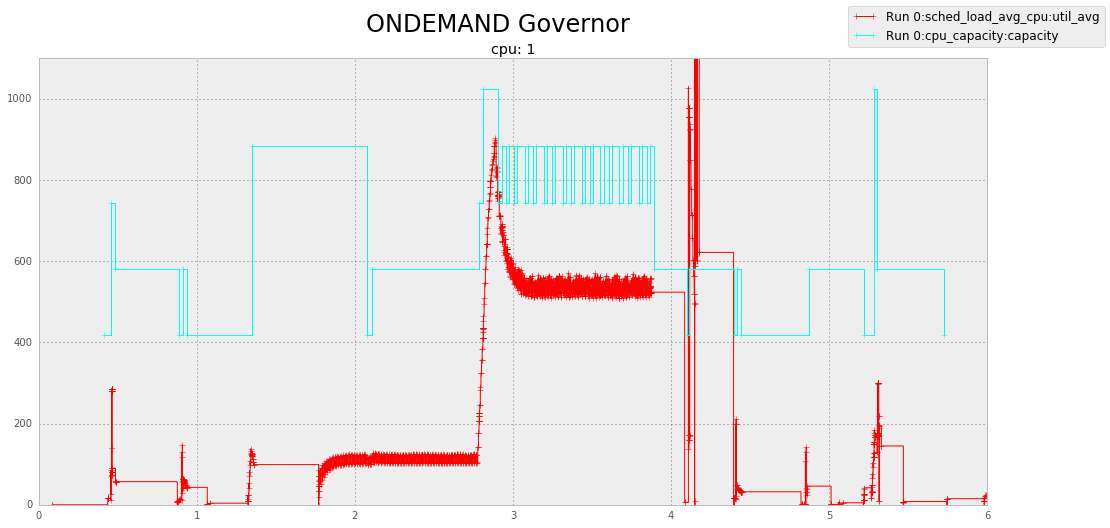

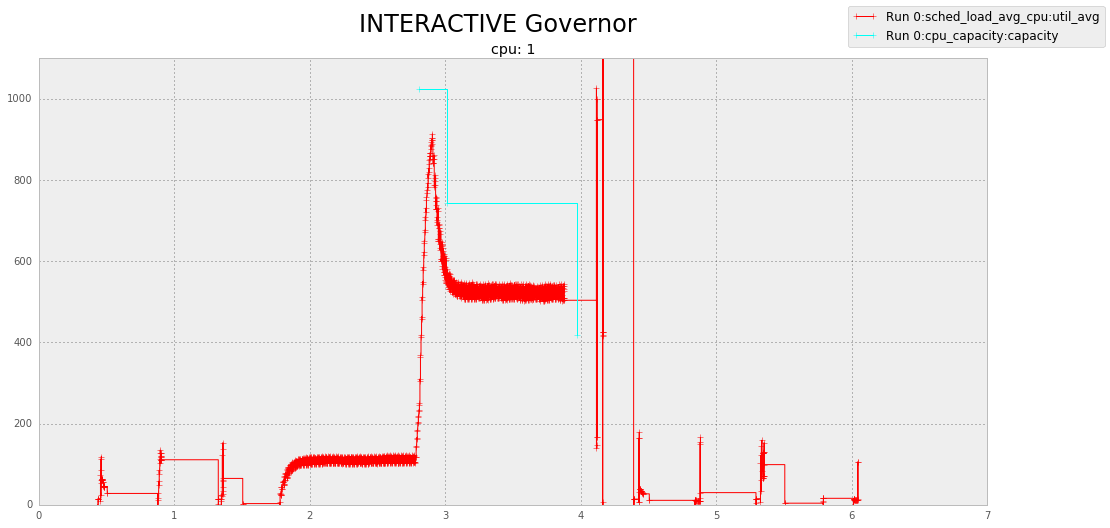

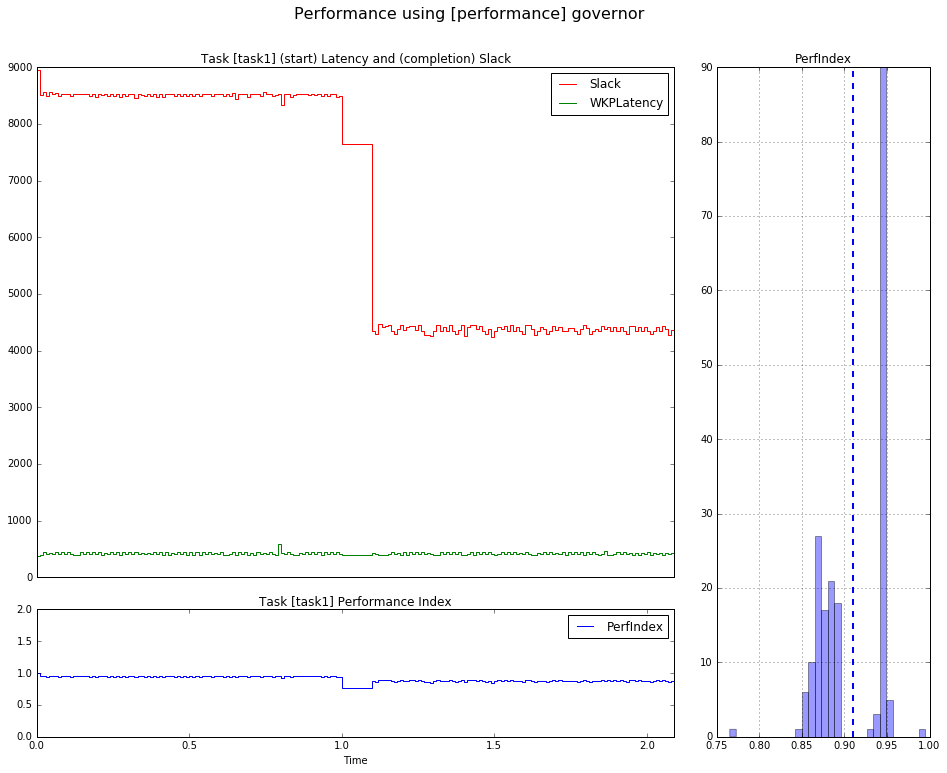

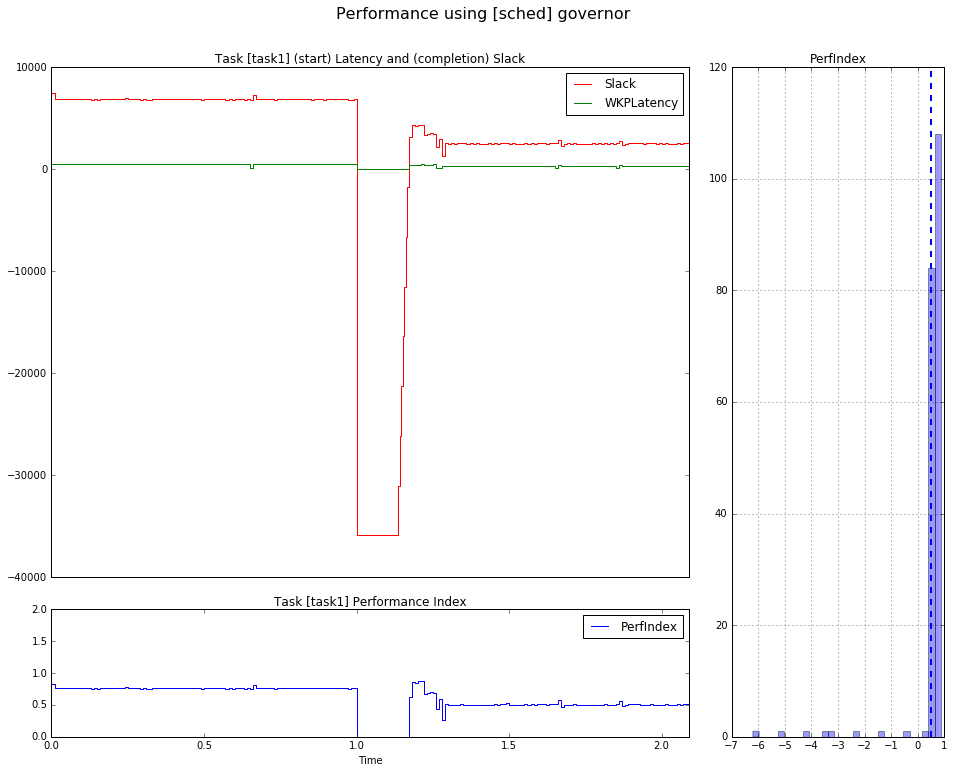

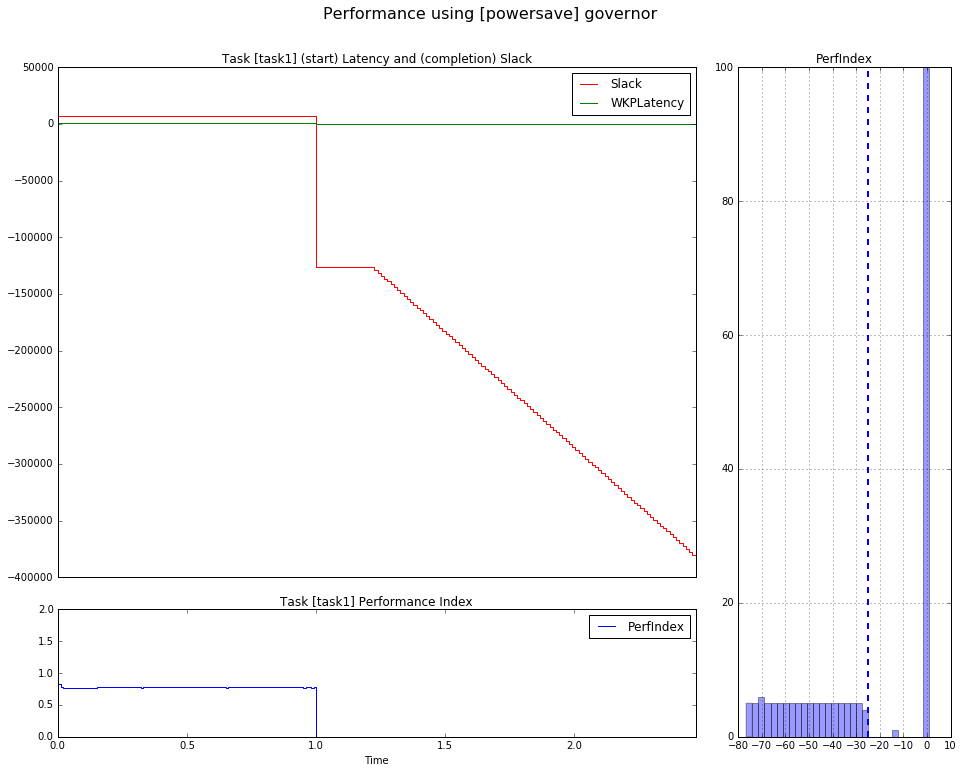

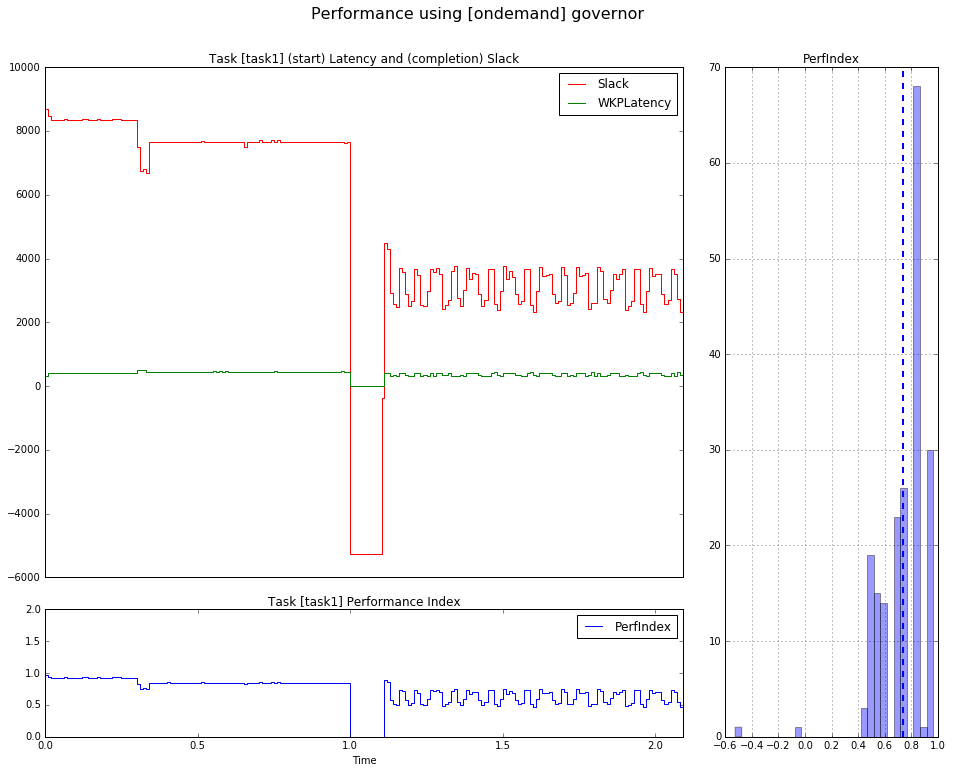

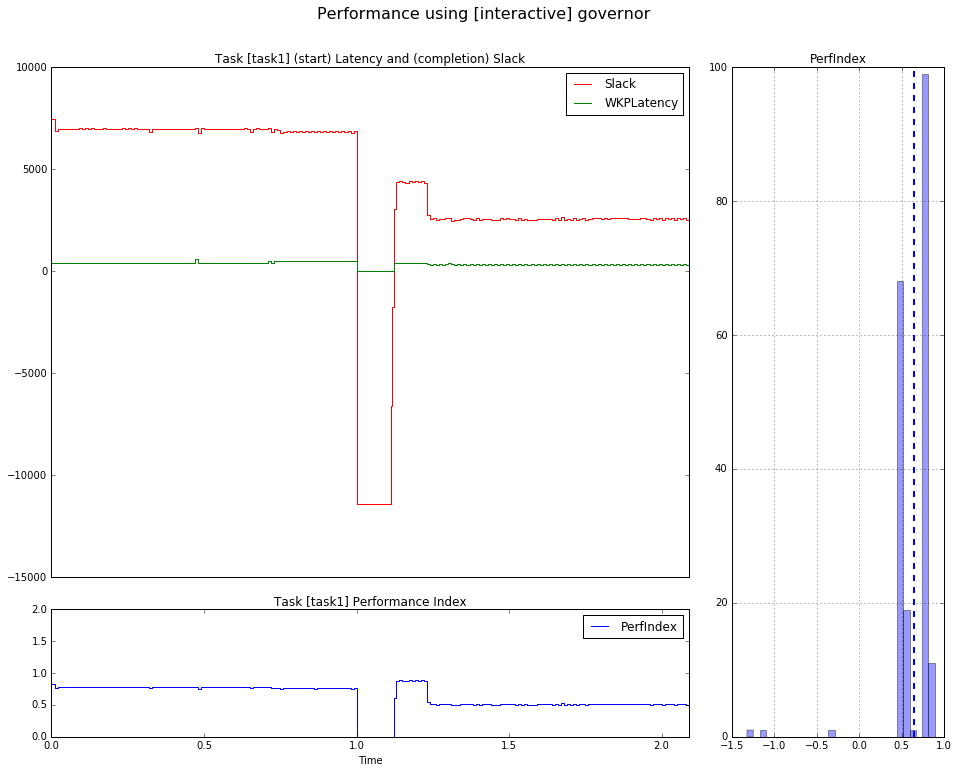

In [16]:
plot(test_case)

In [17]:
report_nrg(test_case)

Governor        |       A53       A57     Total
----------------+------------------------------
performance     |     0.894     7.293     8.187
sched           |     0.625     5.585     6.210
powersave       |     0.586     4.619     5.205
ondemand        |     0.613     6.063     6.676
interactive     |     0.573     5.604     6.177
